In [1]:
import nltk
import string
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.metrics import roc_curve, roc_auc_score
from nltk.corpus import words
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


**Заметка**
Мой метод очистки стоп-слов и прочего мусора из текста немного грубый, по сути через "фильт" проходят только грамматически правильные слова из-за чего некоторые информативные слова (например аббревиатуры, слэнг и др.) не проходят, но зато удаляется абсолютно весь шум. В целом модель работает на уровне других похожих моделей из соревнования, уступая Bert'ам, разумеется. Но зато словарь в памяти в половину меньше (~7 000 vs ~15 000).



**1: Pre-processing**

In [2]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv') 
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_ids = test['id'].copy()

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
train_set, val_set = train_test_split(train, test_size = 0.2)

print(train_set['target'].value_counts())
print(val_set['target'].value_counts())

0    3474
1    2616
Name: target, dtype: int64
0    868
1    655
Name: target, dtype: int64


In [7]:
# location как фича довольно бесполезная в данной задаче, а вот keyword, добавим в основной текст
# сперва заменим NaN токеном "http", так как потом его уберём вместе со всеми остальными стоп словами
train_set['keyword'].fillna('http', inplace = True)
val_set['keyword'].fillna('http', inplace = True)
test['keyword'].fillna('http', inplace = True)


train_set['all_words'] = train_set['text'] + ' ' + train_set['keyword']
val_set['all_words'] = val_set['text'] + ' ' + val_set['keyword']
test['all_words'] = test['text'] + ' ' + test['keyword']


In [8]:
val_labels = val_set['target'].copy()
val_labels = val_labels.to_numpy()
val_set = val_set['all_words'].copy()
train_labels = train_set['target'].copy()
train_labels = train_labels.to_numpy()
train_set = train_set['all_words'].copy()
test = test['all_words'].copy()

In [9]:
# этап очистки
word_set = set(words.words())
word_set.add('forrest')
stop_words = stopwords.words('english')
some_more_stop_words = ['http', 'https', 'cant', 'oh', 'b', 'rt','yeah', 'dont', 'bc', 
                        'cause', 'hello', 'wow', 'yo', 'mr', 'miss', 'ah', 'abc', 'aw', 
                        'aka', 'ahh', 'att', 'aa', 'aan', 'aa', 'aar', 'ay', 'and', 'aia', 
                        'akx','but', 'bye', 'com', 'ee', 'yay', 'yr', 'yh', 'ya', 'yet', 
                        'yyj', 'yyc', 'yup', 'ye', 'yea', 'yep', 'ohh', 'ovo', 'ok', 'ooh', 
                        'of', 'if', 'im', 'jez']

# доп стоп-слова добавил, когда увидел, что некоторые попали в итоговый словарь.
stop_words.extend(some_more_stop_words)
stop_words = set(stop_words)

def custom_text_cleaner(test_sent):
    tokens = word_tokenize(test_sent)
    new_tokens = []
    
    for token in tokens:
        
        extra_in_word_bool = False
        
        if token not in word_set:
            if token.casefold() not in word_set:
                continue
        
        if token.casefold() in stop_words:
            continue
            
        
        new_tokens.append(token.casefold())
            
    return ' '.join(new_tokens)


def count_words(series):
    counts = Counter()
    for tweet in series.values:
        for word in tweet.split():
            counts[word] += 1
    return counts

In [10]:
train_tweets = train_set.apply(custom_text_cleaner)
val_tweets = val_set.apply(custom_text_cleaner)
test_tweets = test.apply(custom_text_cleaner)


feature_number = len(max(train_tweets, key=len).split())
vocab_counted = count_words(train_tweets) + count_words(val_tweets)
num_words_in_vocab = len(vocab_counted)

In [11]:
# этап токенизации
tokenizer = Tokenizer(num_words = num_words_in_vocab)
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, maxlen = feature_number, padding = 'pre')
val_sequences = tokenizer.texts_to_sequences(val_tweets)
val_padded = pad_sequences(val_sequences, maxlen = feature_number, padding = 'pre')
test_sequences = tokenizer.texts_to_sequences(test_tweets)
test_padded = pad_sequences(test_sequences, maxlen = feature_number, padding = 'pre')

**2: Создаём модель**

In [12]:
sequential_nn_model = keras.models.Sequential()
sequential_nn_model.add(keras.layers.Embedding(num_words_in_vocab, 64, 
                                               input_length = feature_number, 
                                               mask_zero = True))
sequential_nn_model.add(keras.layers.LSTM(128, dropout = 0.3, return_sequences = True))
sequential_nn_model.add(keras.layers.LSTM(32, dropout = 0.1))
sequential_nn_model.add(keras.layers.Dense(1, activation = 'sigmoid'))

sequential_nn_model.summary()

2022-07-03 20:39:24.161345: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 64)            429440    
_________________________________________________________________
lstm (LSTM)                  (None, 21, 128)           98816     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 548,897
Trainable params: 548,897
Non-trainable params: 0
_________________________________________________________________


In [13]:
sequential_nn_model.compile(loss = 'binary_crossentropy',
                            optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-3),
                            metrics = ['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint("best_model_1.h5")

history = sequential_nn_model.fit(train_padded, train_labels, epochs = 5,
                                  validation_data = (val_padded, val_labels),
                                  callbacks = [checkpoint_cb])

sequential_nn_model = keras.models.load_model("best_model_1.h5")

Epoch 1/5


2022-07-03 20:39:26.255390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


191/191 [==============================] - 24s 79ms/step - loss: 0.5368 - accuracy: 0.7256 - val_loss: 0.4760 - val_accuracy: 0.7708
Epoch 2/5
191/191 [==============================] - 13s 67ms/step - loss: 0.3674 - accuracy: 0.8507 - val_loss: 0.5402 - val_accuracy: 0.7728
Epoch 3/5
191/191 [==============================] - 13s 69ms/step - loss: 0.2679 - accuracy: 0.8954 - val_loss: 0.5907 - val_accuracy: 0.7695
Epoch 4/5
191/191 [==============================] - 13s 67ms/step - loss: 0.2070 - accuracy: 0.9204 - val_loss: 0.7290 - val_accuracy: 0.7636
Epoch 5/5
191/191 [==============================] - 13s 68ms/step - loss: 0.1699 - accuracy: 0.9317 - val_loss: 0.7472 - val_accuracy: 0.7452


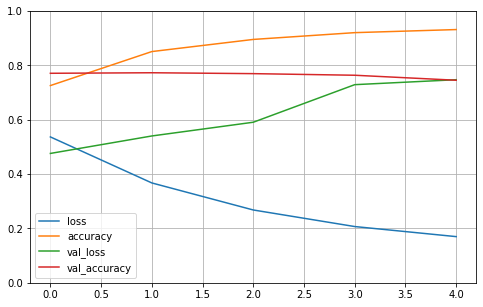

In [14]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

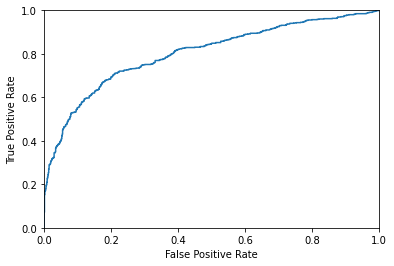

In [15]:
y_val_proba = sequential_nn_model.predict(val_padded).ravel()
fpr, tpr, thresholds = roc_curve(val_labels, y_val_proba)

def plot_roc_curve(fpr,tpr): 
    plt.plot(fpr,tpr)
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()    

plot_roc_curve (fpr,tpr) 

In [16]:
predictions = sequential_nn_model.predict(test_padded)
predictions = tf.squeeze(tf.round(predictions))
predictions = tf.round(predictions.numpy())

In [17]:
sub = pd.DataFrame({'id' : test_ids,'target' : predictions})
sub['target'] = sub['target'].apply(int)
sub.to_csv('submission.csv',  index = False)
print(sub.head())

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
